In [609]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import partial
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

## Control of oscillations (OOP version)

In [ ]:
# To define an oscillation class, required properties are model (model), parameters (params), constants (consts) and the conservative relations of species (calc_all)
# Format of calc_all: calc_all(sol: solution of solve_ivp, consts: np.array) -> all concentrations: np.array
# Species are strictly in the order of (A2, S, A, O)
class oscillation:
    def __init__(self, model, params, consts, calc_all):

        # Model and parameters
        self.__model = model
        self.__params = params
        self.__consts = consts
        self.__calc_all = calc_all

        # Essential information
        self.__species = ['A2', 'S_total', 'A', 'O']
        self.__info = None

        # Experimental data
        self.__exp_data = None

    @property
    def info(self):
        print(
            f'The model includes {len(self.__params)} parameters and {len(self.__consts)} constants. The species are {self.__species}.')
        print(f'Additional information: {self.__info}')

    def add_info(self, info):
        self.__info = info

    def simulate(self, init_cond, t=10, t_eval='default'):
        params_pass = np.hstack((self.__params, self.__consts))
        model_partial = partial(self.__model, params=params_pass)
        t_span = (0, t)

        if type(t_eval) == str:
            t_eval = np.linspace(0, t, 500)
        sol = solve_ivp(model_partial, t_span=t_span,
                        y0=init_cond, t_eval=t_eval, rtol=1e-6, atol=1e-8)
        return sol

    def plot(self, init_cond, t=10, exp=False):
        i = 0
        if exp == True:
            sol = self.simulate(init_cond, t=self.__exp_data.iloc[-1, 0])
            c = self.__calc_all(sol, self.__consts)
            fig, axes = plt.subplots(3, 1, figsize=(8, 12))
            for ax in axes:
                ax.plot(
                    self.__exp_data.iloc[:, 2*i], self.__exp_data.iloc[:, 2*i+1], label=f'exp-{self.__species[i]}')
                ax.plot(sol.t, c[i], label=self.__species[i])
                ax.legend()
                i += 1
        else:
            sol = self.simulate(init_cond, t)
            c = self.__calc_all(sol, self.__consts)
            fig, axes = plt.subplots(2, 2, figsize=(10, 6))
            for ax, y in zip(axes.flatten(), c):
                ax.plot(sol.t, y, label=self.__species[i])
                ax.legend()
                i += 1

        return fig, ax

    def interactive_plot(self, init_cond, t=10, range=5, step=0.05, exp=False):

        if len(self.__params) == 4:
            print('4 parameters')

            def plot_temp(alpha, beta, theta, phi):
                params_old = self.__params
                params = [alpha, beta, theta, phi]
                self.__params = params
                self.plot(init_cond, t, exp=exp)
                self.__params = params_old

            alpha, beta, theta, phi = self.__params
            alpha_slider = widgets.FloatSlider(value=alpha, min=max(
                0, alpha-range), max=alpha+range, step=step, description='alpha')
            beta_slider = widgets.FloatSlider(value=beta, min=max(
                0, beta-range), max=beta+range, step=step, description='beta')
            theta_slider = widgets.FloatSlider(value=theta, min=max(
                0, theta-range), max=theta+range, step=step, description='theta')
            phi_slider = widgets.FloatSlider(value=phi, min=max(
                0, phi-range), max=phi+range, step=step, description='phi')

            interactive_widget = widgets.interactive(
                plot_temp, alpha=alpha_slider, beta=beta_slider, theta=theta_slider, phi=phi_slider)
            display(interactive_widget)

        elif len(self.__params) == 5:
            print('5 parameters')
            pass

    def add_exp_data(self, exp_data):
        print(
            f'The species are {self.__species}. Please check if the data is in the same order and correct format (time, concentration).')
        data = exp_data.clip(lower=0)
        self.__exp_data = data

    def set_params(self, params):
        self.__params = params

    def fit(self, plot=False):
        tA2 = np.array(self.__exp_data.iloc[:, 0])
        cA2 = np.array(self.__exp_data.iloc[:, 1])
        tS = np.array(self.__exp_data.iloc[:, 2])
        cS = np.array(self.__exp_data.iloc[:, 3])

        if self.__exp_data.shape[1] >= 4:
            tA = np.array(self.__exp_data.iloc[:, 4])
            cA = np.array(self.__exp_data.iloc[:, 5])

        t_span_A2 = tA2[-1]
        t_span_S = tS[-1]
        init_cond = [cA2[0], cS[0]]

        def objective(params):
            self.__params = params
            simA2 = self.simulate(init_cond, t=t_span_A2, t_eval=tA2)
            simS = self.simulate(init_cond, t=t_span_S, t_eval=tS)
            c_all_A2 = self.__calc_all(simA2, self.__consts)
            c_all_S = self.__calc_all(simS, self.__consts)

            penalty = 1e10 * np.sum(np.minimum(self.__params, 0) ** 2)

            obj = np.sum((c_all_A2[0] - cA2)**2 +
                         (c_all_S[1] - cS)**2) + penalty
            return obj

        params_old = self.__params

        opt_result = sp.optimize.minimize(
            objective, self.__params, method='Nelder-Mead', tol=1e-6)
        print(
            f'alpha = {self.__params[0]:.3f}, beta = {self.__params[1]:.3f}, theta = {self.__params[2]:.3f}, phi = {self.__params[3]:.3f}')

        if plot == True:
            self.plot(init_cond, exp=True)

        self.__params = params_old
        return opt_result

In [618]:
# Params includes alpha, beta, theta, phi, lam, m in the final model

def model1(t, vars, params):
    alpha, beta, theta, phi, lam, m = params
    C_A2, C_S = vars
    dC_A2dt = 1 - alpha * C_A2 * C_S**m - theta * C_A2
    dC_Sdt = alpha/lam * C_A2 * C_S**m - beta * \
        C_S**(m + 1) + theta/lam * C_A2 - phi * C_S
    return (dC_A2dt, dC_Sdt)

def calculate_all_conc(sol, consts):
    lam, m = consts
    C_A2 = sol.y[0]
    C_S = sol.y[1]
    C_M = C_S ** m
    C_A = 2 * (1 - C_A2) - lam * (C_S + C_M)
    C_O = 1 / (2 * (1 - C_A2) - lam * (C_S + C_M)) ** 2
    return np.array([C_A2, C_S + C_M, C_A, C_O])

In [619]:
files = ['Data_sets/1_expB_osc_NatChem_MH.csv',
         'Data_sets/3b_expB_osc_NatChem_MH.csv',
         'Data_sets/4_expB_osc_NatChem_MH.csv']

df_list = [pd.read_csv(file) for file in files]

exp_data = pd.concat(df_list, axis=1)

exp_data.columns = ['t1', 'c1', 't3b', 'c3b', 't4', 'c4']

cut_off, CMC_3b = 112, 0.52
C_A2tol = exp_data.loc[0, 'c1'] + exp_data.loc[0, 'c4'] / 2

exp_data = exp_data.head(cut_off)
exp_data[['c1', 'c4']] /= C_A2tol
exp_data['c3b'] /= CMC_3b

for s in ['t1', 't3b', 't4']:
    exp_data = exp_data.drop_duplicates(subset=s)

exp_data = exp_data.clip(lower=0)

In [620]:
params = np.array([24, 1, 3, 10])
consts = np.array([0.17, 4])
init_cond = np.array([0.1, 0])

model_test = oscillation(model1, params, consts, calculate_all_conc)
model_test.add_info('This is a test model. The original Fernando\'s model')
model_test.add_exp_data(exp_data)

The species are ['A2', 'S_total', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


alpha = 26.447, beta = -0.000, theta = 3.412, phi = 10.723


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23.657242524035222
             x: [ 2.645e+01 -1.676e-11  3.412e+00  1.072e+01]
           nit: 332
          nfev: 593
 final_simplex: (array([[ 2.645e+01, -1.676e-11,  3.412e+00,  1.072e+01],
                       [ 2.645e+01, -1.865e-11,  3.412e+00,  1.072e+01],
                       ...,
                       [ 2.645e+01, -2.090e-11,  3.412e+00,  1.072e+01],
                       [ 2.645e+01, -1.687e-11,  3.412e+00,  1.072e+01]]), array([ 2.366e+01,  2.366e+01,  2.366e+01,  2.366e+01,
                        2.366e+01]))

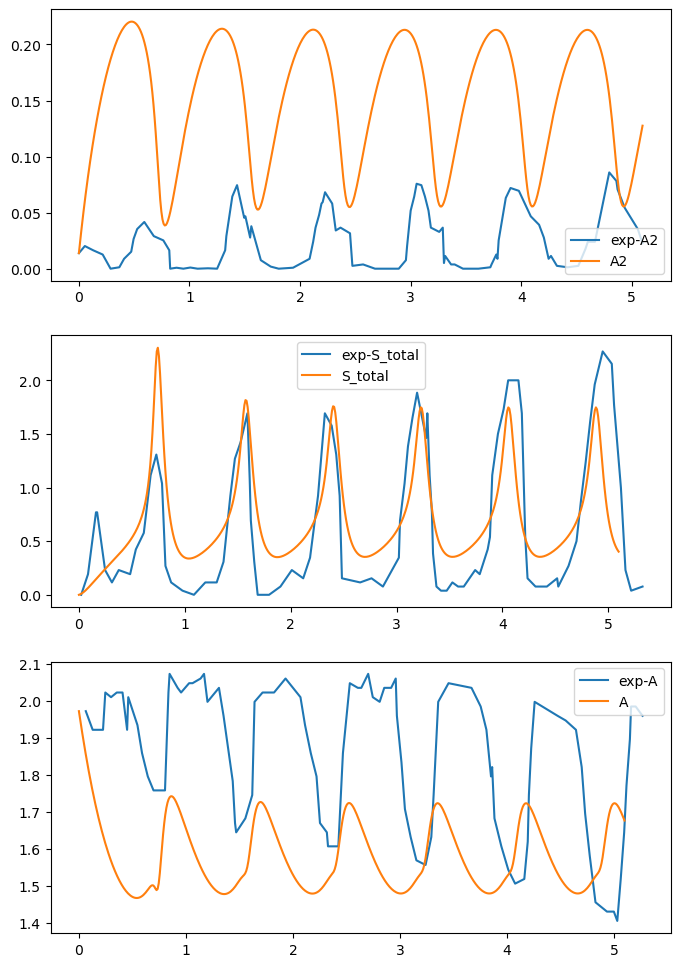

In [622]:
model_test.fit(plot=True)